<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/Glide_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Inpainting for Web Images

paste in an image URL, make your mask and give a text prompt to condition the generation over the mask

# Imports and Setup

In [ ]:
#@title Download from Github
!git clone https://github.com/openai/glide-text2im.git

%cd /content/glide-text2im/
!pip install -e .
!pip install ftfy

Cloning into 'glide-text2im'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 66 (delta 23), reused 34 (delta 14), pack-reused 10
Unpacking objects: 100% (66/66), done.
/content/glide-text2im
Obtaining file:///content/glide-text2im
     |████████████████████████████████| 64 kB 700 kB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=34082e13785df9662f824be1fdfe57ed54505879b5d056edde16778b1e90ab9a
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Running setup.py develop for glide-text2im


In [ ]:
#@title Imports

from typing import Tuple

import requests

from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [ ]:
#@title
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(f"Running on {device}")

Running on cuda


In [ ]:
# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))


  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

In [ ]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

def read_mask(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    tup = th.from_numpy(img)[None].permute(0,3, 1, 2).float() / 127.5 - 1
    tup, _ = th.max(tup, 1, keepdim=True)
    return (tup == -1) * 1

def download_image(path: str) -> None:
    response = requests.get(path)
    if response.status_code == 200:
      with open("base_image.jpg", 'wb') as f:
        f.write(response.content)

def show_image(batch: th.Tensor, number):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    start = 0+(256*number)
    end = start + 256
    subset = reshaped.numpy()[:,start:end,:]
    display(Image.fromarray(subset))

# Making A Mask for our Image

In [ ]:
src="https://afar-production.imgix.net/uploads/images/post_images/images/lpeKsVTM4r/original_emperor-penguin-antarctica-sue-flood.jpg?auto=compress,format&lossless=true&w=845" #@param {type: "string"}

download_image(src)

The Following Cell needs to be run each time you want to redraw and save the mask,  If the cell is not running then the save button will not do anything

In [ ]:
#@title Make your mask
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<h2> Erase the part of the image you want to infill, then click Save </h2>
<canvas width=%d height=%d style="background: url('%s'); background-size: 512px 512px;"></canvas> 
<button>Save</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.strokeStyle = 'rgba(255, 0, 0, 0.5)';
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='mask.png', url='', w=512, h=512, line_width=20):
  display(HTML(canvas_html % (w, h, url, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)
draw(url=src)

10430

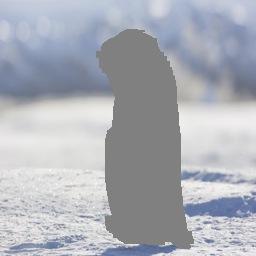

In [ ]:
#@title Parameters
prompt = "a meerkat in the snow" #@param {type: "string"}
batch_size =  10#@param {type: "number"}
guidance_scale =  5#@param {type: "number"}

#@markdown Tune this parameter to control the sharpness of 256x256 images.
#@markdown <br>A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997 #@param {type: "number"}


# Source image we are inpainting
source_image_256 = read_image('base_image.jpg', size=256)
source_image_64 = read_image('base_image.jpg', size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = read_mask('mask.png',64)
source_mask_256 = read_mask('mask.png',256)

# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

  0%|          | 0/100 [00:00<?, ?it/s]

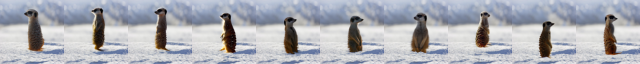

In [ ]:
#@title Sample From the Base Model at 64 * 64
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

# Create an classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

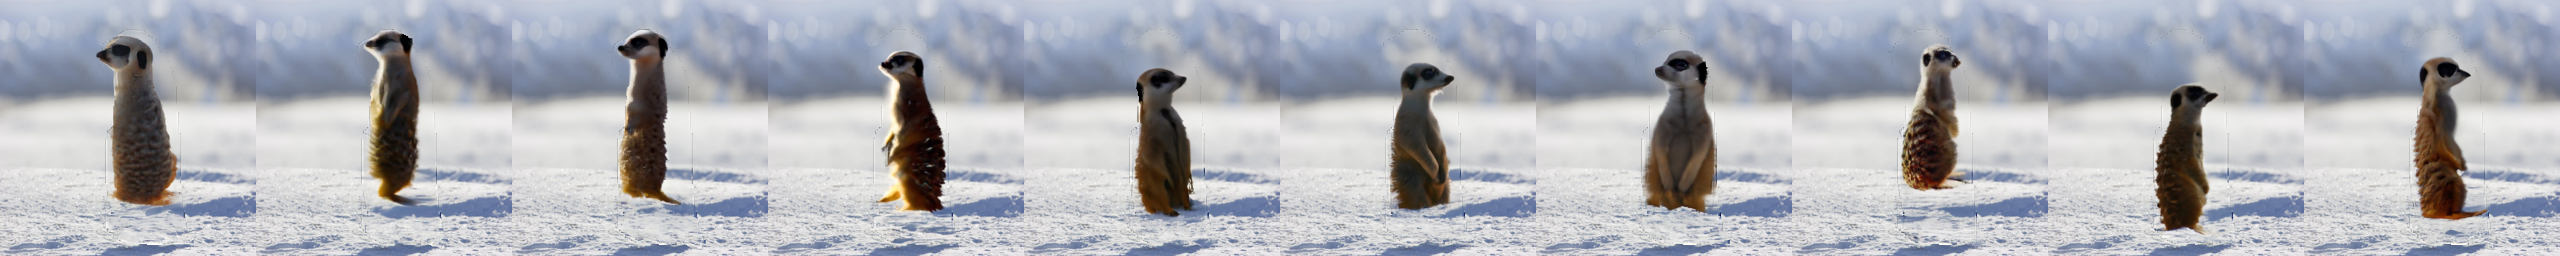

a meerkat in the snow


In [ ]:
#@title Upsample the 64 * 64 to 256 * 256
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

# Show the output

show_images(up_samples)
print(prompt)

a meerkat in the snow


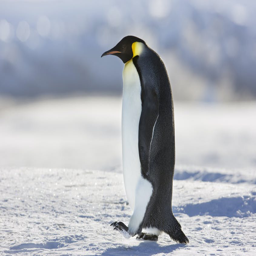

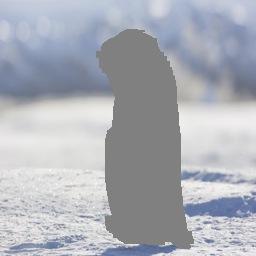

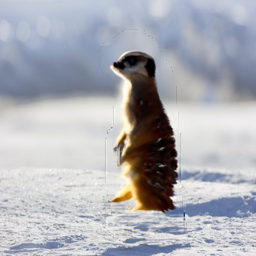

In [ ]:
print(prompt)
show_images(source_image_256)
show_images(source_image_256 * source_mask_256)
show_image(up_samples, 3)
